In [1]:
%load_ext autoreload
%matplotlib inline

import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image  

import hyperhyper as hy
import dataset
import math

from adjustText import adjust_text

import logging
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [2]:
# color interpol
from colormath.color_objects import sRGBColor
from colormath.color_conversions import convert_color

def hex_to_rgb_color(hex):
    return sRGBColor(*[int(hex[i + 1:i + 3], 16) for i in (0, 2 ,4)], is_upscaled=True)

def create_palette(start_color, end_color, n, colorspace=sRGBColor):
    start_rgb = hex_to_rgb_color(start_color)
    end_rgb = hex_to_rgb_color(end_color)

    # convert start and end to a point in the given colorspace
    start = convert_color(start_rgb, colorspace).get_value_tuple()
    end = convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [color.get_rgb_hex() for color in rgb_colors]

In [3]:
# select some config to get compareable results
def get_best(year):
    b = hy.Bunch(f'/mnt/data2/ptf/bunches/bi_{year}_decay_4')
    db = dataset.connect(f'sqlite:////mnt/data2/ptf/bunches/bi_{year}_decay_4/results.db')
    statement = 'SELECT * FROM experiments where pair_args__dynamic_window="decay" ORDER BY micro_results DESC LIMIT 1'
    
    for best in list(db.query(statement)):
        oov = True if best['pair_args__delete_oov'] == 1 else False
        window = int(best['pair_args__window'])
        if not isinstance(window, int):
            window = int.from_bytes(window, "little")
        neg = float(best['neg'])
        if neg.is_integer():
            neg = int(neg)
        dim = int(best['dim'])
            
        print(oov, best)
        try:
            print(best['neg'])
            kv, res = b.svd(impl='scipy', evaluate=True, pair_args={'subsample': 'deter', 'subsample_factor': best['pair_args__subsample_factor'], 'delete_oov': True, 'decay_rate': 0.33, 'window': window, 'dynamic_window': 'decay'}, neg=1, eig=0.35, dim=dim, keyed_vector=True)
            print(res)
            print(best)
        except Exception as e:
            print(e)
    return kv

In [4]:
kvs = [get_best(year) for year in [2010, 2012, 2014, 2016, 2018]]

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


True OrderedDict([('id', 320), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_window', 'decay'), ('pair_args__decay_rate', 0.33), ('pair_args__delete_oov', 1.0), ('pair_args__subsample', 'deter'), ('pair_args__subsample_factor', 7e-05), ('neg', 1.2999999999999998), ('eig', 0.35000000000000003), ('dim', 500.0), ('micro_results', 0.5486674539152988), ('macro_results', 0.6126339441738009), ('ws353rel_score', 0.6503565815779454), ('ws353rel_oov', 0.09126984126984126), ('ws353rel_fullscore', 0.5909986396085297), ('schm280_score', 0.7243885580601162), ('schm280_oov', 0.09642857142857143), ('schm280_fullscore', 0.6545368042471764), ('gur65_score', 0.6398429688717551), ('gur65_oov', 0.16923076923076924), ('gur65_fullscore', 0.5315618510626888), ('simlex999_score', 0.3920119068931563), ('simlex999_oov', 0.16016016016016016), ('simlex999_fullscore', 0.3292272171004586), ('gur350_score', 0.76170852511226), ('gur350_oov', 0.3057142857142857), ('gur350_fulls

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5435200273596196, 'macro': 0.6096955569739652, 'results': [{'name': 'de_ws353rel', 'score': 0.6487241989422079, 'oov': 0.09126984126984126, 'fullscore': 0.5895152442768476}, {'name': 'de_schm280', 'score': 0.7192856852373851, 'oov': 0.09642857142857143, 'fullscore': 0.649925994160923}, {'name': 'de_gur65', 'score': 0.6344654962240279, 'oov': 0.16923076923076924, 'fullscore': 0.527094412247654}, {'name': 'de_simlex999', 'score': 0.38245319907333497, 'oov': 0.16016016016016016, 'fullscore': 0.32119943345598406}, {'name': 'de_gur350', 'score': 0.7634253725211106, 'oov': 0.3057142857142857, 'fullscore': 0.5300353300646569}, {'name': 'de_ws353sim', 'score': 0.631072521726856, 'oov': 0.11940298507462686, 'fullscore': 0.5557205788340971}, {'name': 'de_zg222', 'score': 0.4884424250928333, 'oov': 0.40540540540540543, 'fullscore': 0.2904252257308738}]}
OrderedDict([('id', 320), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_win

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
Exception during reset or similar
Traceback (most recent call last):
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.d

svd
k pair_args
{'micro': 0.5364966640622338, 'macro': 0.5992332973979577, 'results': [{'name': 'de_ws353rel', 'score': 0.6476206162558953, 'oov': 0.09126984126984126, 'fullscore': 0.5885123854071429}, {'name': 'de_schm280', 'score': 0.7103747622071744, 'oov': 0.09642857142857143, 'fullscore': 0.6418743387086255}, {'name': 'de_gur65', 'score': 0.5927042724704025, 'oov': 0.16923076923076924, 'fullscore': 0.4924004725138728}, {'name': 'de_simlex999', 'score': 0.37337142239810794, 'oov': 0.15415415415415415, 'fullscore': 0.31581466659299423}, {'name': 'de_gur350', 'score': 0.7732826276305903, 'oov': 0.29428571428571426, 'fullscore': 0.545716597213588}, {'name': 'de_ws353sim', 'score': 0.6153360207158861, 'oov': 0.1044776119402985, 'fullscore': 0.5510471827306443}, {'name': 'de_zg222', 'score': 0.48194336010764754, 'oov': 0.3963963963963964, 'fullscore': 0.2909027488938053}]}
OrderedDict([('id', 330), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_w

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5475387792947616, 'macro': 0.6100387667565702, 'results': [{'name': 'de_ws353rel', 'score': 0.631239583888831, 'oov': 0.0992063492063492, 'fullscore': 0.568616609296685}, {'name': 'de_schm280', 'score': 0.6893668830980597, 'oov': 0.09642857142857143, 'fullscore': 0.6228922193707468}, {'name': 'de_gur65', 'score': 0.6832084428877289, 'oov': 0.18461538461538463, 'fullscore': 0.5570776534315327}, {'name': 'de_simlex999', 'score': 0.40626242093767884, 'oov': 0.15515515515515516, 'fullscore': 0.34322871198338434}, {'name': 'de_gur350', 'score': 0.7630545925111348, 'oov': 0.3142857142857143, 'fullscore': 0.5232374348647781}, {'name': 'de_ws353sim', 'score': 0.6417684253502799, 'oov': 0.1044776119402985, 'fullscore': 0.5747179928509969}, {'name': 'de_zg222', 'score': 0.4553710186222781, 'oov': 0.4369369369369369, 'fullscore': 0.25640260057560704}]}
OrderedDict([('id', 128), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_wind

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5779414537525829, 'macro': 0.6583453839091951, 'results': [{'name': 'de_ws353rel', 'score': 0.6342369333176447, 'oov': 0.0992063492063492, 'fullscore': 0.5713166026313705}, {'name': 'de_schm280', 'score': 0.7236024821632894, 'oov': 0.09285714285714286, 'fullscore': 0.6564108231052697}, {'name': 'de_gur65', 'score': 0.7822058463277819, 'oov': 0.2, 'fullscore': 0.6257646770622256}, {'name': 'de_simlex999', 'score': 0.4257408160247589, 'oov': 0.14914914914914915, 'fullscore': 0.36224193555660167}, {'name': 'de_gur350', 'score': 0.7979397924119788, 'oov': 0.3171428571428571, 'fullscore': 0.5448788868184655}, {'name': 'de_ws353sim', 'score': 0.678673419005287, 'oov': 0.11442786069651742, 'fullscore': 0.6010142715569208}, {'name': 'de_zg222', 'score': 0.5660183981136258, 'oov': 0.4189189189189189, 'fullscore': 0.32890258268764744}]}
OrderedDict([('id', 152), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_window', 'decay'), 

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.582858122163073, 'macro': 0.657297424446643, 'results': [{'name': 'de_ws353rel', 'score': 0.675555498047015, 'oov': 0.1111111111111111, 'fullscore': 0.6004937760417911}, {'name': 'de_schm280', 'score': 0.7414352255645436, 'oov': 0.1, 'fullscore': 0.6672917030080893}, {'name': 'de_gur65', 'score': 0.747468698034066, 'oov': 0.16923076923076924, 'fullscore': 0.6209739952898394}, {'name': 'de_simlex999', 'score': 0.42814308878508545, 'oov': 0.15215215215215216, 'fullscore': 0.36300019639736475}, {'name': 'de_gur350', 'score': 0.788386817561373, 'oov': 0.3171428571428571, 'fullscore': 0.5383555697061947}, {'name': 'de_ws353sim', 'score': 0.7037057573357987, 'oov': 0.12935323383084577, 'fullscore': 0.6126791419590287}, {'name': 'de_zg222', 'score': 0.5163868857986191, 'oov': 0.4009009009009009, 'fullscore': 0.3093669180685421}]}
OrderedDict([('id', 28), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_window', 'decay'), ('pai

In [5]:
# kvs = [kv1, kv2, kv3, kv4]

In [6]:
def get_most_similar(w, kv, num=10):
    names = [w]
    vecs = [kv[w]]
    for name, _ in kv.most_similar(w, topn=num + 10):
        names.append(name)
        vecs.append(kv[name])
    for idx, n in enumerate(names):
        for n2 in names:
            if n == n2:
                continue
            if n[:-1] == n2 and n[-1] in ('s', 'n'):
                del names[idx]
                del vecs[idx]
            
    return names[:num], vecs[:num]

In [7]:
def push_out(a, forced_len=1.45):
    """
    push a vector to the given lenght
    """
    a = np.array(a)
    if np.absolute(a.max()) > 0.8:
        forced_len = 1.45
    cof = forced_len/np.linalg.norm(a)
    return a * cof

In [8]:
push_out([0.9, 0])

array([1.45, 0.  ])

In [9]:
def align_orth(m1, m2, names1, names2):
    m1_reordered = []
    m2_reordered = []
    for idx2, n2 in enumerate(names2):
        if n2 in names1:
            idx1 = names1.index(n2)
            m1_reordered.append(m1[idx1])
            m2_reordered.append(m2[idx2])
    transformation_matrix, score = orthogonal_procrustes(m2_reordered, m1_reordered)
    return transformation_matrix

In [10]:
def get_all(words, kv):
    return words, [kv[w] for w in words]

In [11]:
def add_missing_tokens(points):
    """
    Find and eliminate gaps for tokens in the scences. This happens when token x is in scene 2 and 4. To avoid gaps, add to scene 3 as well.
    This can happen because of some instability. So this is only a cosmetic 'fix'.
    """
    all_names = set()
    for x in points:
        all_names.update(x[0])

    for n in all_names:
        indices = []
        for i, p in enumerate(points):
            if n in p[0]:
                indices.append(i)
        min_i = min(indices)
        max_i = max(indices)
        for i in range(min_i, max_i + 1):
            if i not in indices:
                points[i][0].append(n)
                points[i][1].append(kvs[i][n])
    return points

In [12]:
def get_annotation_position(ans, pos):
    fig, ax = plt.subplots()
    
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    # size of the figure
    fig.set_size_inches(8, 8)
    
    ax.scatter(pos[:, 0], pos[:, 1], color='black')
    
    texts = [plt.text(pos[i][0], pos[i][1], ans[i], weight='regular') for i in range(len(ans))]
    fixed_pos = adjust_text(texts, weight='regular')
    return fixed_pos

[((-0.7943092481620605, -0.09112386342558709), 'bottom', 'left'),
 ((-0.2453963351403946, 0.5516241929557065), 'center', 'left'),
 ((-0.4455828670834799, 0.6153132120768678), 'bottom', 'left'),
 ((-0.3121334340003373, -0.46484449359503666), 'bottom', 'left'),
 ((-0.9056703579135014, -0.9954472977594033), 'bottom', 'left'),
 ((-0.8289011676515705, 0.3595476163493996), 'bottom', 'left'),
 ((-0.46441961585553465, 0.5197549729138727), 'top', 'left'),
 ((-0.8944546830799912, -0.18855843507492526), 'bottom', 'left'),
 ((-0.8100879075302536, 0.09682708175598909), 'bottom', 'left'),
 ((-0.9869170320377972, -0.5912245413922332), 'bottom', 'left'),
 ((-0.9914750106158886, -0.8536326762992261), 'bottom', 'left'),
 ((-0.4942780394579633, 1.0045527022405971), 'bottom', 'left'),
 ((0.9951706450466518, -0.016471136572223988), 'bottom', 'right'),
 ((0.8138734932165416, -0.4160085629556505), 'bottom', 'left'),
 ((0.9163507298683865, -0.3248650692895779), 'bottom', 'right'),
 ((0.9150117690341296, -0.25

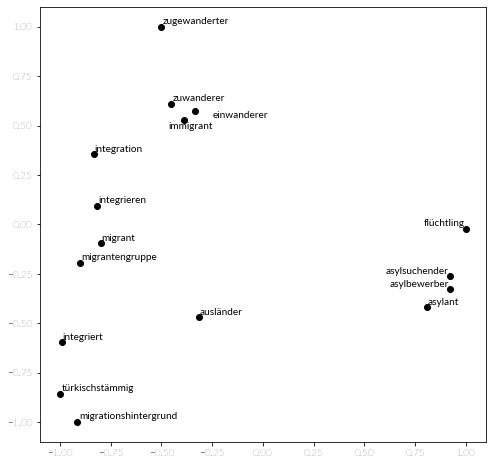

In [22]:
get_annotation_position(s[0][0], s[1][0])

In [29]:
def get_settings(w, most_similar=10):
    # the n points of the current scene in focus
    cur_points = [get_most_similar(w, kv, most_similar) for kv in kvs]
    cur_points = add_missing_tokens(cur_points)
    
    names = [[] for _ in range(len(kvs))]
    next_points_outside = [[] for _ in range(len(kvs))]
    
    leaving_points = [[] for _ in range(len(kvs))]
    leaving_names = [[] for _ in range(len(kvs))]

    incoming_points = [[] for _ in range(len(kvs))]
    incoming_names = [[] for _ in range(len(kvs))]
        
    for i in range(len(cur_points)):
        # fill array with names + values
        p = cur_points[i]    
        scene_names = p[0]
        names[i] = scene_names
        cur_points[i] = p[1]
    
    # insert the points that will appear in the next scene to current scne
    # because we are iterating over the names, add the names after the main loops
    for i in reversed(range(1, len(cur_points))):
        for n_idx, na in enumerate(names[i]):
            if na in names[i - 1]:
                continue
            if na in kvs[i - 1]:
                # move in
                names[i - 1].append(na)
                cur_points[i - 1].append(kvs[i - 1][na])
            else:
                # fade in
                incoming_names[i - 1].append(na)
    
    # check if names are present in subsequent scenes
    # not for the last scene
    for i in range(len(cur_points) - 1):  
        for na in names[i]:
            if na in names[i + 1]:
                continue
            if na in kvs[i + 1]:
                next_points_outside[i].append(na)
            else:
                leaving_names[i].append(na)
                
    # get the excapt number of points per scene
    num_points = [len(x) for x in cur_points]
    
    # final location of the next_locations
    next_points = [[0] * len(x) for x in cur_points]
    
    # now project onto 2d
    for i in range(len(cur_points)):
        n = num_points[i]
        # 1. work on the n focus points
        c_p = PCA(n_components=2).fit_transform(cur_points[i][:n])
        c_p = MinMaxScaler((-1, 1)).fit_transform(c_p)
        
        # 2. focus on a global view with more points
        c_p_2 = PCA(n_components=2).fit_transform(cur_points[i])
        # so the others are outside [-1, 1]
        c_p_2 = MinMaxScaler((-1, 1)).fit(c_p_2[:n]).transform(c_p_2)
        
        # align, based on the first n 
        matrix, _ = orthogonal_procrustes(c_p_2[:n], c_p)
        c_p_2 = c_p_2.dot(matrix)
        cur_points[i] = np.vstack((c_p, c_p_2[n:]))

        if i > 0:
            matrix = align_orth(cur_points[i - 1], cur_points[i], names[i - 1], names[i])
            # after aligning, points can be outside [-1, 1], so re-scale
            cur_points[i] = MinMaxScaler((-1, 1)).fit_transform(cur_points[i].dot(matrix))
                        
            # 1. points that are also in the next scene should move to the location in the next scene
            for na in set(names[i]).intersection(names[i - 1]):
                next_points[i - 1][names[i - 1].index(na)] = cur_points[i][names[i].index(na)]
                
            # 2. fading out should not move
            for na in leaving_names[i-1]:
                na_idx = names[i - 1].index(na)
                next_points[i - 1][na_idx] = cur_points[i - 1][na_idx]
            
            # 3. map points that are outside the focus (in the scence) to some points
            # this make sure, that points are moving off the scene in the right direction
            cmp = len(names[i])
            # location for other points
            all_names = names[i] + next_points_outside[i - 1]
            ps = [kvs[i][x] for x in all_names]
            ps = PCA(n_components=2).fit_transform(ps)
            ps = MinMaxScaler((-1, 1)).fit(ps[:n]).transform(ps)            
            
            matrix2, _ = orthogonal_procrustes(ps[:cmp], cur_points[i][:cmp])
            ps = ps.dot(matrix2)
            for na_i, na in enumerate(next_points_outside[i - 1]):
                na_idx = names[i - 1].index(na)
                next_points[i - 1][na_idx] = push_out(ps[na_i + cmp])
            
            # 4. set position for fading in points
            incoming_points[i - 1] = [cur_points[i][names[i].index(na)] for na in incoming_names[i - 1]]
            
            # 5. leaving points
            leaving_points[i - 1] = [cur_points[i - 1][names[i - 1].index(na)] for na in leaving_names[i - 1]]
            # this is some kind of hack, we remove the points again so it's easier for the animation
            for na in leaving_names[i - 1]:
                idx = names[i - 1].index(na)
                del names[i - 1][idx]
                cur_points[i - 1] = np.delete(cur_points[i - 1], idx, axis=0)
                next_points[i - 1] = np.delete(next_points[i - 1], idx, axis=0)

            
    # the last scene should not move
    next_points[-1] = cur_points[-1]
    
    # get final position for annotations
    ans_points = [[list(x) for x in get_annotation_position(names[i], cur_points[i])] for i in range(len(cur_points))]
    
    return names, cur_points, next_points, leaving_names, leaving_points, incoming_names, incoming_points, ans_points


In [30]:
from matplotlib import rcParams

rcParams['font.family'] = 'lato'
special_blue = '#800080'
frames_cof = 0.01

In [47]:
def get_anim(names, cur_points, next_points, leaving_names, leaving_points, incoming_names, incoming_points, ans_points):
    num_scenes = len(names)
    
    # colors user later on for fading in
    colors = create_palette(special_blue, '#000000', int((1/frames_cof) * 0.1), sRGBColor)

    # the scene with the most numbers
    max_names = max([len(x) for x in names])
    max_incoming_names = max([len(x) for x in incoming_names])
    max_leaving_names = max([len(x) for x in leaving_names])

    fig, ax = plt.subplots()
    # increase the size so text / dots that are close to the border are visible
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    # size of the figure
    fig.set_size_inches(8, 8)
    
    fig.suptitle(f'ähnliche Wörter zu »{names[0][0]}«', fontsize=16, weight='regular')
    
    ax.axis('off')
    # scatter dot positions
    scat = ax.scatter([], [])
    scat_incoming = ax.scatter([], [])
    scat_leaving = ax.scatter([], [])
    
    # annotations
    ans = []
    ans_incoming = []
    ans_leaving = []

    # year label
    year = ax.annotate("", xy=(0.5, 1.1), weight='regular', fontsize=30, color='grey')

    def init():
        scat.set_offsets(cur_points[0])
        scat.set_color(['red'] + ['#000000'] * 30)
        scat.set_sizes([50] + [30] * 30)
        
        scat_leaving.set_color('#000000')
        scat_incoming.set_sizes([30] * 30)
        scat_leaving.set_sizes([30] * 30)

        for _ in range(max_names):
            ans.append(ax.annotate("", xy=(0, 0), weight='regular'))
        for _ in range(max_incoming_names):
            ans_incoming.append(ax.annotate("", xy=(0, 0), weight='regular'))
        for _ in range(max_leaving_names):
            ans_leaving.append(ax.annotate("", xy=(0, 0), weight='regular'))
        return (scat, scat_incoming, year, *ans, *ans_incoming, *ans_leaving)

    def animate(t):
        cur_set = math.floor(t)
        cur_ans_point = list(zip(*ans_points[cur_set]))
        
        # static for 50% of the time and moving 50% of the time
        t -= cur_set
        adj_t = (t - 0.5) * 2

        year.set_text(str(2010 + cur_set * 2) + '/' + str(2011 + cur_set * 2))

        if t > 0.5:
            interpolation = (
                np.array(cur_points[cur_set]) * (1 - adj_t)
                + np.array(next_points[cur_set]) * adj_t
            )
            interpolation_ans = (
                np.array(cur_ans_point[0]) * (1 - adj_t)
                + np.array(next_points[cur_set]) * adj_t
            )
        else:
            interpolation = cur_points[cur_set]
            interpolation_ans = cur_ans_point[0]

        
        # filter out points that are outside [-1, 1]
        interpolation = np.where(interpolation > -1.01, interpolation, 10 * interpolation)
        interpolation = np.where(interpolation < 1.01, interpolation, 10 * interpolation)
   
        # clear old scatter points
        interpolation = np.concatenate((interpolation, np.ones((20, 2)) + 10), axis=0)
        scat.set_offsets(interpolation)

        # clear old text
        for idx in range(max_incoming_names):
            ans_incoming[idx].set_text('')        
        
        if len(incoming_points[cur_set]) > 0 and t > 0.5:
            current_color = special_blue
            if adj_t >= 0.8:
                # somewhat complicated calculation. We only want to interpolate the color for 10% of the moving time.
                # so we are doing some crazy tricks. The adj_t is already some cray trick
                c_index = int(round((adj_t - 0.8) * 50))
                current_color = colors[c_index]

            scat_incoming.set_visible(True)
            scat_incoming.set_offsets(incoming_points[cur_set])
            scat_incoming.set_alpha(adj_t)
            scat_incoming.set_color(current_color)
            
            for idx, n in enumerate(incoming_names[cur_set]):
                ans_incoming[idx].set_position(np.array(incoming_points[cur_set][idx]) + (0.03, -0.025))
                ans_incoming[idx].set_text(n)
                ans_incoming[idx].set_alpha(adj_t)
                ans_incoming[idx].set_fontsize(12)
                ans_incoming[idx].set_color(current_color)
        else:
            scat_incoming.set_visible(False)

        # clear old text
        for idx in range(max_leaving_names):
            ans_leaving[idx].set_text('')  
            
        if len(leaving_points[cur_set]) > 0:
            scat_leaving.set_visible(True)
            scat_leaving.set_offsets(leaving_points[cur_set])
            
            # fade out
            if t > 0.5:
                scat_leaving.set_alpha(1 - adj_t)
            
            for idx, n in enumerate(leaving_names[cur_set]):
                ans_leaving[idx].set_position(np.array(leaving_points[cur_set][idx]) + (0.03, -0.025))
                ans_leaving[idx].set_text(n)
                ans_leaving[idx].set_fontsize(12)
                if t > 0.5:
                    ans_leaving[idx].set_alpha(1 - adj_t)
        else:
            scat_leaving.set_visible(False)
            
        updated_idx = 0
        for idx, n in enumerate(names[cur_set]):
            updated_idx += 1
            ans[idx].set_position(interpolation_ans[idx])
            ans[idx].set_va(cur_ans_point[1][idx])
            ans[idx].set_ha(cur_ans_point[2][idx])
            ans[idx].set_text(n)
            if idx == 0:
                ans[idx].set_fontsize(16)
                ans[idx].set_color('red')
            else:
                ans[idx].set_fontsize(12)

        # clear old annotations
        while updated_idx < len(ans):
            ans[updated_idx].set_text("")
            updated_idx += 1

        return (scat, scat_incoming, year, *ans, *ans_incoming)

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=np.arange(0, num_scenes, frames_cof),
        interval=60,
        blit=True,
    )
    return anim

In [48]:
token = 'migrant'

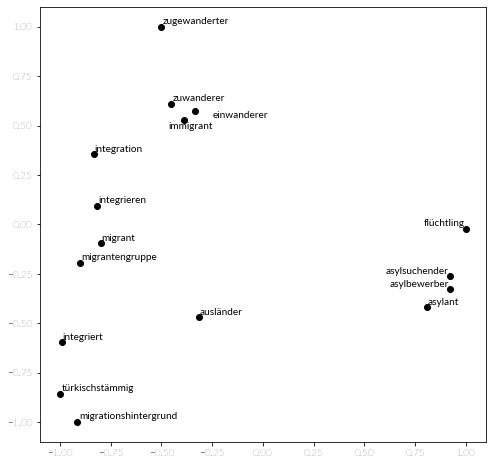

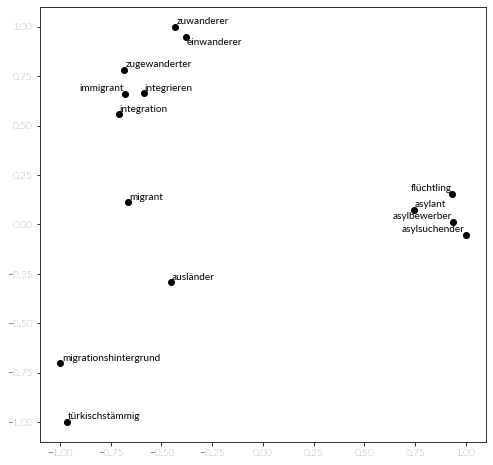

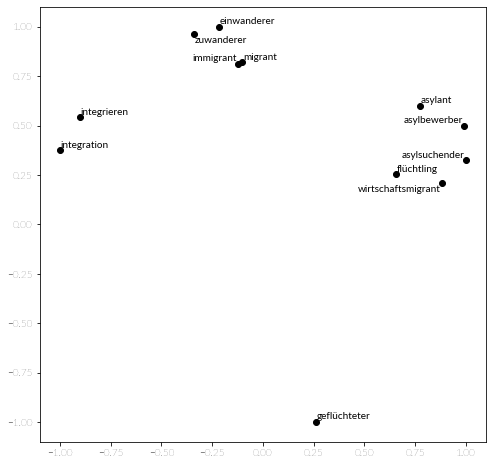

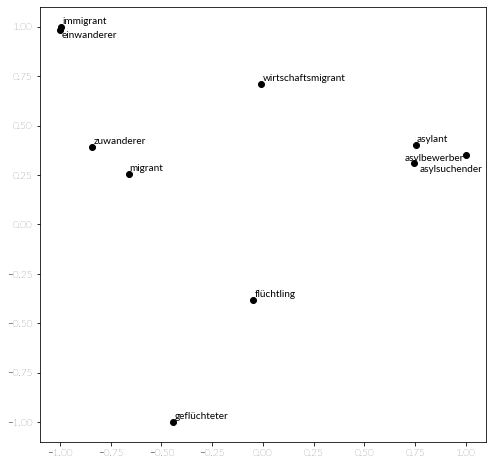

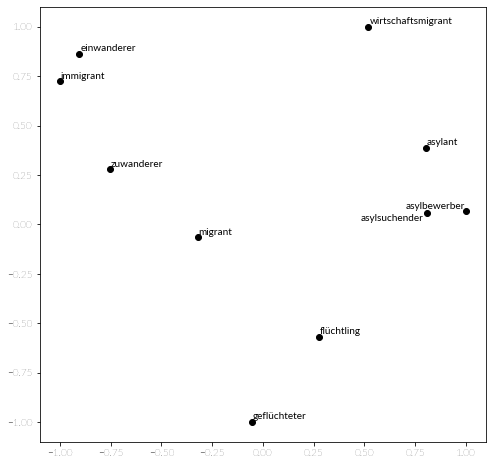

In [49]:
s = get_settings(token)

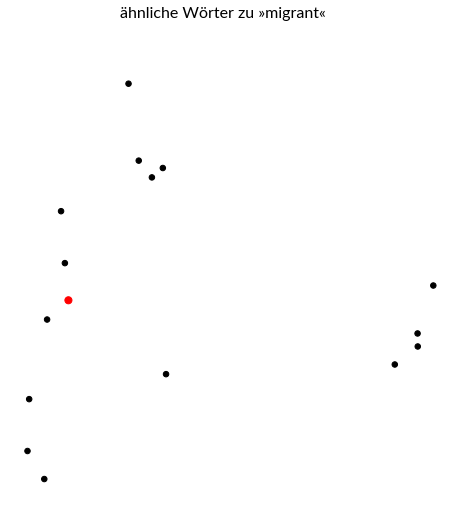

In [50]:
a = get_anim(*s)

In [51]:
# a.save(f'{token}.mp4') # extra_args=['-vcodec', 'libx264']

In [52]:
HTML(a.to_html5_video())